# Project - March Madness Predictions
**Completed by: Audrey Chan**

Goal of project is to determine a "half-decent" 🙂 classification model to make NCAA March Madness first round predictions, using data from 2003 to 2017. Model will be built on using 1) regular season data and 2) team seeding into the NCAA tournament as predictors. 

In this Jupyter Notebook, it walks through the process of data cleaning, EDA, pre-processing and trying to optimize the model.

**Contents**
- [Import Libraries](#Import-Libraries)
- [Import Data](#Import-Data)
- [Merge Data and Cleaning (i.e. throwing out columns)](#Merge-Data-and-Cleaning-(i.e.-throwing-out-columns))
- [Train, Test, Split](#Train,-Test,-Split)
- [Naive/Baseline Model](#Naive/Baseline-Model)
- [Model (based on all features)](#Model-(based-on-all-features))
- [Predicting March Madness! (validating the model based on years)](#Predicting-March-Madness!-(validating-the-model-based-on-years))
- [Model Improvement (i.e. feature selection, hyperparameters)](#Model-Improvement-(i.e.-feature-selection,-hyperparameters))
- [Conclusion](#Conclusion)

### Import Libraries

In [1]:
import pandas as pd
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
import warnings
from sklearn.exceptions import DataConversionWarning

### Import Data

The data is spread across four files:
- `regular_season.csv` - gamelogs for every regular season game
- `teams.csv` - team_id, names, and conferences
- `march_madness.csv` - gamelogs for each NCAA tournament game
- `march_madness_seeds.csv` - entry seeds for each team (W, X, Y, Z indicate the region)

In [2]:
reg_season = pd.read_csv('data/regular_season.csv')
teams = pd.read_csv('data/teams.csv')
ncaa = pd.read_csv('data/march_madness.csv')
seeds = pd.read_csv('data/march_madness_seeds.csv')

In [3]:
# peak in data
reg_season.head()

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score,winning_team_field_goals,winning_team_field_goals_attempted,winning_team_three_points,winning_team_three_points_attempted,...,losing_team_three_points_attempted,losing_team_free_throws,losing_team_free_throws_attempted,losing_team_offensive_rebounds,losing_team_defensive_rebounds,losing_team_assists,losing_team_turnovers,losing_team_steals,losing_team_blocks,losing_team_personal_fouls
0,2003,10,1104,68,1328,62,27,58,3,14,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,26,62,8,20,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,24,58,8,18,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,18,38,3,9,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,30,61,6,14,...,16,17,27,21,15,12,10,7,1,14


In [4]:
teams.head()

,season,team_id,team_name,conference_code,conference_name
0,2014,1101,Abilene Chr,southland,Southland Conference
1,2015,1101,Abilene Chr,southland,Southland Conference
2,2016,1101,Abilene Chr,southland,Southland Conference
3,2017,1101,Abilene Chr,southland,Southland Conference
4,2018,1101,Abilene Chr,southland,Southland Conference


In [5]:
ncaa.head()

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


In [6]:
seeds.head()

,season,seed,team_id
0,2003,W01,1328
1,2003,W02,1448
2,2003,W03,1393
3,2003,W04,1257
4,2003,W05,1280


### Merge Data and Cleaning (i.e. throwing out columns)

##### Seeds dataset:

In [7]:
# remove letters from seed and convert to int type
seeds['seed'] = seeds['seed'].str[1:3].astype(int)
seeds.head()

,season,seed,team_id
0,2003,1,1328
1,2003,2,1448
2,2003,3,1393
3,2003,4,1257
4,2003,5,1280


In [8]:
# check null and dtypes are all numerical
seeds.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 3 columns):
season     996 non-null int64
seed       996 non-null int64
team_id    996 non-null int64
dtypes: int64(3)
memory usage: 23.4 KB


##### NCAA dataset:

In [9]:
# keep only 2003 years and later
ncaa = ncaa[ncaa['season'] >= 2003] 

In [10]:
# check null and dtypes are all numerical
ncaa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 1136 to 2116
Data columns (total 6 columns):
season                981 non-null int64
day_in_season         981 non-null int64
winning_team_id       981 non-null int64
winning_team_score    981 non-null int64
losing_team_id        981 non-null int64
losing_team_score     981 non-null int64
dtypes: int64(6)
memory usage: 53.6 KB


##### Regular season dataset:

In [11]:
# check all numeric columns
reg_season.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76636 entries, 0 to 76635
Data columns (total 32 columns):
season                                 76636 non-null int64
day_in_season                          76636 non-null int64
winning_team_id                        76636 non-null int64
winning_team_score                     76636 non-null int64
losing_team_id                         76636 non-null int64
losing_team_score                      76636 non-null int64
winning_team_field_goals               76636 non-null int64
winning_team_field_goals_attempted     76636 non-null int64
winning_team_three_points              76636 non-null int64
winning_team_three_points_attempted    76636 non-null int64
winning_team_free_throws               76636 non-null int64
winning_team_free_throws_attempted     76636 non-null int64
winning_team_offensive_rebounds        76636 non-null int64
winning_team_defensive_rebounds        76636 non-null int64
winning_team_assists                   76636 non-nu

In [12]:
# separate winning and losing team stats, to make it easier to match with team ID when combining tables together
reg_win = reg_season.filter(regex = 'winning|season')
reg_lose = reg_season.filter(regex = 'losing|season')
reg_win.head(3)

,season,day_in_season,winning_team_id,winning_team_score,winning_team_field_goals,winning_team_field_goals_attempted,winning_team_three_points,winning_team_three_points_attempted,winning_team_free_throws,winning_team_free_throws_attempted,winning_team_offensive_rebounds,winning_team_defensive_rebounds,winning_team_assists,winning_team_turnovers,winning_team_steals,winning_team_blocks,winning_team_personal_fouls
0,2003,10,1104,68,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1272,70,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1266,73,24,58,8,18,17,29,17,26,15,10,5,2,25


##### NCAA / Seeds / Regular Season combined dataset:

In [13]:
# add seeding of teams into NCAA dataset 
data = pd.merge(ncaa, seeds, how = 'left', left_on = ['season', 'winning_team_id'],
                                    right_on = ['season', 'team_id'])
data = pd.merge(data, seeds, how = 'left', left_on = ['season', 'losing_team_id'],
                                    right_on = ['season', 'team_id'])
data.head(3)

,season,day_in_season,winning_team_id,winning_team_score,losing_team_id,losing_team_score,seed_x,team_id_x,seed_y,team_id_y
0,2003,134,1421,92,1411,84,16,1421,16,1411
1,2003,136,1112,80,1436,51,1,1112,16,1436
2,2003,136,1113,84,1272,71,10,1113,7,1272


In [14]:
# add reg season stats into df
reg_win = reg_win.groupby(['season', 'winning_team_id']).median()
reg_lose = reg_lose.groupby(['season', 'losing_team_id']).median()
reg_win.head(3)

day_in_season  winning_team_score  \
season winning_team_id                                      
2003   1102                      56.0                69.0   
       1103                      86.0                85.0   
       1104                      49.0                76.0   

                        winning_team_field_goals  \
season winning_team_id                             
2003   1102                                 23.0   
       1103                                 31.0   
       1104                                 26.0   

                        winning_team_field_goals_attempted  \
season winning_team_id                                       
2003   1102                                           40.5   
       1103                                           53.0   
       1104                                           58.0   

                        winning_team_three_points  \
season winning_team_id                              
2003   1102                                   9.0   
       1103                                   4.0   
       1104                                   7.0   

                        winning_team_three_points_attempted  \
season winning_team_id                                        
2003   1102                                            21.5   
       1103                                            13.0   
       1104                                            21.0   

                        winning_team_free_throws  \
season winning_team_id                             
2003   1102                                 12.0   
       1103                                 21.0   
       1104                                 15.0   

                        winning_team_free_throws_attempted  \
season winning_team_id                                       
2003   1102                                           20.0   
       1103                                           27.0   
       1104                                           23.0   

                        winning_team_offensive_rebounds  \
season winning_team_id                                    
2003   1102                                         4.5   
       1103                                         9.0   
       1104                                        13.0   

                        winning_team_defensive_rebounds  winning_team_assists  \
season winning_team_id                                                          
2003   1102                                        21.5                  18.0   
       1103                                        21.0                  17.0   
       1104                                        26.0                  14.0   

                        winning_team_turnovers  winning_team_steals  \
season winning_team_id                                                
2003   1102                               10.5                  7.0   
       1103                               12.0                  8.0   
       1104                               13.0                  7.0   

                        winning_team_blocks  winning_team_personal_fouls  
season winning_team_id                                                    
2003   1102                             2.5                         16.0  
       1103                             2.0                         20.0  
       1104                             4.0                         16.0

In [15]:
data = pd.merge(data, reg_win, how = 'left', left_on = ['season', 'winning_team_id'],
                      right_on = ['season', 'winning_team_id'])
data = pd.merge(data, reg_lose, how = 'left', left_on = ['season', 'losing_team_id'],
                                    right_on = ['season', 'losing_team_id'])
data.head(3)

,season,day_in_season_x,winning_team_id,winning_team_score_x,losing_team_id,losing_team_score_x,seed_x,team_id_x,seed_y,team_id_y,...,losing_team_three_points_attempted,losing_team_free_throws,losing_team_free_throws_attempted,losing_team_offensive_rebounds,losing_team_defensive_rebounds,losing_team_assists,losing_team_turnovers,losing_team_steals,losing_team_blocks,losing_team_personal_fouls
0,2003,134,1421,92,1411,84,16,1421,16,1411,...,20.0,12.0,22.0,13.0,20.0,11.5,12.5,7.0,2.0,17.5
1,2003,136,1112,80,1436,51,1,1112,16,1436,...,18.0,9.5,15.5,12.5,23.5,11.0,16.0,5.0,2.0,16.5
2,2003,136,1113,84,1272,71,10,1113,7,1272,...,21.0,16.5,25.0,13.0,22.5,13.5,13.0,7.0,5.0,20.5


In [16]:
# drop unwanted columns, believed not to be important features
data.columns

Index(['season', 'day_in_season_x', 'winning_team_id', 'winning_team_score_x',
       'losing_team_id', 'losing_team_score_x', 'seed_x', 'team_id_x',
       'seed_y', 'team_id_y', 'day_in_season_y', 'winning_team_score_y',
       'winning_team_field_goals', 'winning_team_field_goals_attempted',
       'winning_team_three_points', 'winning_team_three_points_attempted',
       'winning_team_free_throws', 'winning_team_free_throws_attempted',
       'winning_team_offensive_rebounds', 'winning_team_defensive_rebounds',
       'winning_team_assists', 'winning_team_turnovers', 'winning_team_steals',
       'winning_team_blocks', 'winning_team_personal_fouls', 'day_in_season',
       'losing_team_score_y', 'losing_team_field_goals',
       'losing_team_field_goals_attempted', 'losing_team_three_points',
       'losing_team_three_points_attempted', 'losing_team_free_throws',
       'losing_team_free_throws_attempted', 'losing_team_offensive_rebounds',
       'losing_team_defensive_rebounds', '

In [17]:
data = data.drop(['day_in_season_x', 'winning_team_score_x', 'losing_team_score_x', 'team_id_x',
                  'team_id_y', 'day_in_season_y', 'winning_team_score_y', 'day_in_season', 
                  'losing_team_score_y'], axis = 1)

In [18]:
data.columns # remaining columns

Index(['season', 'winning_team_id', 'losing_team_id', 'seed_x', 'seed_y',
       'winning_team_field_goals', 'winning_team_field_goals_attempted',
       'winning_team_three_points', 'winning_team_three_points_attempted',
       'winning_team_free_throws', 'winning_team_free_throws_attempted',
       'winning_team_offensive_rebounds', 'winning_team_defensive_rebounds',
       'winning_team_assists', 'winning_team_turnovers', 'winning_team_steals',
       'winning_team_blocks', 'winning_team_personal_fouls',
       'losing_team_field_goals', 'losing_team_field_goals_attempted',
       'losing_team_three_points', 'losing_team_three_points_attempted',
       'losing_team_free_throws', 'losing_team_free_throws_attempted',
       'losing_team_offensive_rebounds', 'losing_team_defensive_rebounds',
       'losing_team_assists', 'losing_team_turnovers', 'losing_team_steals',
       'losing_team_blocks', 'losing_team_personal_fouls'],
      dtype='object')

In [19]:
# rename columns to stats for team_a and team_b
renames = {'winning_':'team_a_', 'losing_':'team_b_', 'seed_x':'team_a_seed', 'seed_y':'team_b_seed'}
for old, new in renames.items():
    data.columns = data.columns.str.replace(old, new)

##### Add Outcomes Column (win = 1, lose = 0, applicable to team_a of each row)

In [20]:
data['outcome'] = 1

In [21]:
# append duplicate rows, swapping team_a and team_b with outcome 0
duplicate = data.copy()
renames = {'team_a_':'team_interim_', 'team_b_':'team_a_', 'team_interim_':'team_b_'}
for old, new in renames.items():
    duplicate.columns = duplicate.columns.str.replace(old, new)
duplicate['outcome'] = 0

In [22]:
data = pd.concat([data, duplicate], sort = False)

In [23]:
# check null and dtypes are all numerical
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1962 entries, 0 to 980
Data columns (total 32 columns):
season                                1962 non-null int64
team_a_team_id                        1962 non-null int64
team_b_team_id                        1962 non-null int64
team_a_seed                           1962 non-null int64
team_b_seed                           1962 non-null int64
team_a_team_field_goals               1960 non-null float64
team_a_team_field_goals_attempted     1960 non-null float64
team_a_team_three_points              1960 non-null float64
team_a_team_three_points_attempted    1960 non-null float64
team_a_team_free_throws               1960 non-null float64
team_a_team_free_throws_attempted     1960 non-null float64
team_a_team_offensive_rebounds        1960 non-null float64
team_a_team_defensive_rebounds        1960 non-null float64
team_a_team_assists                   1960 non-null float64
team_a_team_turnovers                 1960 non-null float64
team

In [24]:
# remove rows with any nulls
data = data[data.notnull().all(axis=1)]

In [25]:
data.shape # still sufficient rows left

(1958, 32)

### Train, Test, Split

In [26]:
ss_cols = [col for col in data.columns if col not in ['season', 'team_a_team_id', 'team_b_team_id', 'outcome']]

In [27]:
X = data[ss_cols]
y = data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .2, stratify = y)

##### Data Transformation (standardize all feature columns)

In [28]:
column_names = X_train.columns

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

/Users/audreymychan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/audreymychan/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/audreymychan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [29]:
X_train = pd.DataFrame(X_train) # renaming back to original column names
X_train.columns = column_names
X_test = pd.DataFrame(X_test)
X_test.columns = column_names

In [30]:
X_train.head()

,team_a_seed,team_b_seed,team_a_team_field_goals,team_a_team_field_goals_attempted,team_a_team_three_points,team_a_team_three_points_attempted,team_a_team_free_throws,team_a_team_free_throws_attempted,team_a_team_offensive_rebounds,team_a_team_defensive_rebounds,...,team_b_team_three_points_attempted,team_b_team_free_throws,team_b_team_free_throws_attempted,team_b_team_offensive_rebounds,team_b_team_defensive_rebounds,team_b_team_assists,team_b_team_turnovers,team_b_team_steals,team_b_team_blocks,team_b_team_personal_fouls
0,0.221138,-1.271906,-1.050480,-0.074941,-1.191336,-0.390213,1.122054,0.614545,-0.074818,0.318218,...,-0.548873,0.486776,1.348805,0.160724,0.654332,2.154951,1.527475,2.042475,2.574623,-1.575909
1,-0.422546,1.075914,-1.050480,0.285421,-0.249097,-0.250411,0.008432,-0.252908,0.152688,-0.833038,...,-1.114635,-0.318518,-0.521748,-1.190051,0.153998,-0.216812,-1.745430,-0.939268,-0.421557,-1.949829
2,0.864821,-0.204715,0.639179,-0.915786,0.379061,-0.809618,0.644787,1.234155,0.152688,0.153753,...,-0.265991,0.003600,0.725287,-1.640309,-0.846670,-0.946585,0.124802,0.849778,-0.421557,-0.080228
3,1.723065,-1.058468,0.977110,-0.435303,1.635379,0.588399,-0.627923,0.118857,-0.757336,0.976079,...,-0.265991,-0.640636,-1.020563,1.511500,-0.179558,0.148075,-1.277872,-2.131965,0.244261,2.911134
4,1.937626,1.929666,0.808144,0.886025,1.635379,0.728201,0.962965,1.234155,0.607699,-0.010712,...,-0.548873,-1.284871,-0.521748,0.160724,-0.513114,0.148075,3.397707,0.253429,-1.087375,-0.080228


### Naive/Baseline Model

Started with an initial model based on team seeding, using both Logistic Regression and KNN.

In [31]:
# logistic regression
cols = ['team_a_seed', 'team_b_seed']
logreg = LogisticRegression(solver = 'lbfgs')
logreg.fit(X_train[cols], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
print(f'Log reg score (based on seeding) on train data: {cross_val_score(logreg, X_train[cols], y_train, cv = 5)}')
print(f'Log reg score (based on seeding) on test data: {logreg.score(X_test[cols], y_test)}')

Log reg score (based on seeding) on train data: [0.69426752 0.70700637 0.69426752 0.73717949 0.69871795]
Log reg score (based on seeding) on test data: 0.7117346938775511


In [33]:
# knn
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train[cols], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [34]:
print(f'KNN score (based on seeding) on train data: {cross_val_score(knn, X_train[cols], y_train, cv = 5)}')
print(f'KNN score (based on seeding) on test data: {knn.score(X_test[cols], y_test)}')

KNN score (based on seeding) on train data: [0.69745223 0.64012739 0.67197452 0.68910256 0.67307692]
KNN score (based on seeding) on test data: 0.6862244897959183


Naive/baseline models have a score of ~70%, not bad to start!

### Model (based on all features)

In [35]:
logreg = LogisticRegression(solver = 'lbfgs')
logreg.fit(X_train, y_train)
print(f'Log reg score (based on all features) on train data: {cross_val_score(logreg, X_train, y_train, cv = 5)}')
print(f'Log reg score (based on all features) on test data: {logreg.score(X_test, y_test)}')

Log reg score (based on all features) on train data: [1. 1. 1. 1. 1.]
Log reg score (based on all features) on test data: 1.0


*Is this even possible...?*

In [36]:
# check coefficients
flattened_coef = [coef for list in np.exp(logreg.coef_) for coef in list]
pd.DataFrame(zip(X_train.columns, flattened_coef))

,0,1
0,team_a_seed,0.793527
1,team_b_seed,1.221599
2,team_a_team_field_goals,2.437813
3,team_a_team_field_goals_attempted,0.320086
4,team_a_team_three_points,1.902565
5,team_a_team_three_points_attempted,0.587117
6,team_a_team_free_throws,1.713299
7,team_a_team_free_throws_attempted,1.821280
8,team_a_team_offensive_rebounds,0.995011
9,team_a_team_defensive_rebounds,3.464559


### Predicting March Madness! (validating the model based on years)

At this point, to predict March Madness every year, assuming you know the matchups for the first round after the end of the regular season, we will need a pandas dataframe with the following columns where:
- Team A and Team B are to play each other
- One row for each matchup for the first round
- All other columns are their respective regular season averages for each category (i.e. team_a_team_field_goals captures average team field goals for all regular season games for that year for Team A)

In [37]:
data.head(1) # example

,season,team_a_team_id,team_b_team_id,team_a_seed,team_b_seed,team_a_team_field_goals,team_a_team_field_goals_attempted,team_a_team_three_points,team_a_team_three_points_attempted,team_a_team_free_throws,...,team_b_team_free_throws,team_b_team_free_throws_attempted,team_b_team_offensive_rebounds,team_b_team_defensive_rebounds,team_b_team_assists,team_b_team_turnovers,team_b_team_steals,team_b_team_blocks,team_b_team_personal_fouls,outcome
0,2003,1421,1411,16,16,26.0,58.0,6.0,18.0,18.0,...,12.0,22.0,13.0,20.0,11.5,12.5,7.0,2.0,17.5,1


##### First rounds (2003 to 2017)
Seeing how well our models does... because I'm skeptical about the 100% predictions on our train and test data above (maybe something fishy with the code).

In [38]:
# for 2003 to 2017, return accuracy score for first round games
def ncaa_predict(df, cols):
    X = df[cols] # all regular season stats
    X = ss.fit_transform(X)
    X = pd.DataFrame(X)
    X.columns = cols
    y_pred = logreg.predict(X)
    return y_pred.sum()/32 # for perfect prediction, all 32 outcomes should be 1s

In [39]:
for year in range(2003, 2018):
    df = data[(data['season'] == year)].head(32) # assuming always 32 games in round 1
    print(f'{year}: {ncaa_predict(df, ss_cols)}')
    
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

2003: 0.4375
2004: 0.46875
2005: 0.40625
2006: 0.5
2007: 0.40625
2008: 0.53125
2009: 0.375
2010: 0.5625
2011: 0.5
2012: 0.5
2013: 0.40625
2014: 0.40625
2015: 0.5
2016: 0.5625
2017: 0.4375


Model seems to be predict about 50% of previous years' first round outcomes correctly.

### Model Improvement (i.e. feature selection, hyperparameters)

##### Model Based Feature Selection (Logistic Regression)

In [40]:
select = SelectFromModel(LogisticRegression(solver = 'lbfgs', max_iter = 5000), max_features = 15)

In [41]:
select.fit(X_train, y_train)
X_train_lr = select.transform(X_train)

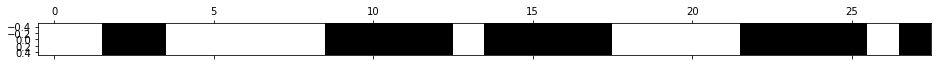

In [42]:
mask = select.get_support()

# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [43]:
cols = X_train.columns[mask] # column names of the 15 features

In [44]:
X_test_lr = select.transform(X_test)

logreg = LogisticRegression(solver='lbfgs', max_iter = 5000)
logreg.fit(X_train_lr, y_train)

print(f'Log reg score (based on 15 features) on test data: {logreg.score(X_test_lr, y_test)}')

Log reg score (based on 15 features) on test data: 0.9974489795918368


In [45]:
for year in range(2003, 2018):
    df = data[(data['season'] == year)].head(32) # assuming always 32 games in round 1
    print(f'{year}: {ncaa_predict(df, cols)}')

2003: 0.5
2004: 0.5
2005: 0.5
2006: 0.5
2007: 0.4375
2008: 0.4375
2009: 0.5
2010: 0.5
2011: 0.53125
2012: 0.5
2013: 0.46875
2014: 0.5
2015: 0.5
2016: 0.4375
2017: 0.5625


Removing some features seem to improve the model a teeny bit!

##### Choosing Best Hyperparameters

In [46]:
# for SelectFromModel()
n = range(1,29) # total of 29 features
opt_n = 0 # to store optimal score and number of features
opt_score = 0

for n in n:
    select = SelectFromModel(LogisticRegression(solver = 'lbfgs', max_iter = 5000), max_features = n)
    select.fit(X_train, y_train)
    X_train_lr = select.transform(X_train)
    logreg = LogisticRegression(solver='lbfgs', max_iter = 5000)
    logreg.fit(X_train_lr, y_train)
    if logreg.score(X_train_lr, y_train) > opt_score:
        opt_score = logreg.score(X_train_lr, y_train)
        opt_n = n
        mask = select.get_support()
        
print(opt_score)
print(opt_n)

1.0
12


In [47]:
opt_cols = X_train.columns[mask] # 12 column names
opt_cols

Index(['team_a_team_field_goals', 'team_a_team_field_goals_attempted',
       'team_a_team_defensive_rebounds', 'team_a_team_assists',
       'team_a_team_turnovers', 'team_a_team_steals',
       'team_b_team_field_goals', 'team_b_team_field_goals_attempted',
       'team_b_team_defensive_rebounds', 'team_b_team_assists',
       'team_b_team_steals', 'team_b_team_personal_fouls'],
      dtype='object')

In [48]:
X_train = X_train[opt_cols] # cut down train and test data with only identified important features
X_test = X_test[opt_cols]

In [49]:
# for Logistic Regression
lr_params = {'penalty':['l1', 'l2'],
             'C':np.logspace(-5,0,100)}

best_model = RandomizedSearchCV(LogisticRegression(), lr_params, cv = 5, 
                                      n_iter = 10, verbose = 1, n_jobs = 2, random_state = 42)

best_model = best_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    2.2s finished
/Users/audreymychan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [50]:
best_model.best_params_

{'penalty': 'l1', 'C': 0.2477076355991709}

In [51]:
best_model.best_score_

0.9980842911877394

### Conclusion

To predict March Madness every year, assuming you know the matchups for the first round after the end of the regular season, we will need a pandas dataframe with the following columns where:
- Team A and Team B are to play each other
- One row for each matchup for the first round
- 12 ordered columns with the following features for Team A and Team B... corresponding to their respective regular season averages for each category (i.e. team_a_team_field_goals captures average team field goals for all regular season games for that year for Team A)
    1. 'team_a_team_field_goals'
    2. 'team_a_team_field_goals_attempted'
    3. 'team_a_team_defensive_rebounds'
    4. 'team_a_team_assists'
    5. 'team_a_team_turnovers'
    6. 'team_a_team_steals'
    7. 'team_b_team_field_goals'
    8. 'team_b_team_field_goals_attempted'
    9. 'team_b_team_defensive_rebounds'
    10. 'team_b_team_assists'
    11. 'team_b_team_steals'
    12. 'team_b_team_personal_fouls'

In [52]:
X_train.head(1) # example

,team_a_team_field_goals,team_a_team_field_goals_attempted,team_a_team_defensive_rebounds,team_a_team_assists,team_a_team_turnovers,team_a_team_steals,team_b_team_field_goals,team_b_team_field_goals_attempted,team_b_team_defensive_rebounds,team_b_team_assists,team_b_team_steals,team_b_team_personal_fouls
0,-1.05048,-0.074941,0.318218,-0.969243,-0.133022,-1.552643,1.627578,0.374353,0.654332,2.154951,2.042475,-1.575909


##### Final Model Performance / Pipeline

In [53]:
X = data[opt_cols]
y = data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .2, stratify = y)

In [54]:
pipe = Pipeline([
    ('Scaler', StandardScaler()), 
    ('BestModel', best_model)
])

In [55]:
pipe = make_pipeline(StandardScaler(), best_model)

In [56]:
pipe.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.3s finished
/Users/audreymychan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomizedsearchcv', RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_it..._jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1))])

In [57]:
print(f'Log reg score (optimized model) on train data: {pipe.score(X_train, y_train)}')

Log reg score (optimized model) on train data: 0.9993614303959132


In [58]:
print(f'Log reg score (optimized model) on test data: {pipe.score(X_test, y_test)}')

Log reg score (optimized model) on test data: 0.9974489795918368


In [59]:
for year in range(2003, 2018):
    df = data[(data['season'] == year)].head(32) # assuming always 32 games in round 1
    print(f'{year}: {pipe.predict(df[opt_cols])}') # outcome suppose to be all 1s 😮

2003: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2004: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2005: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2006: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2007: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2008: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2009: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2010: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2011: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2012: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2013: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2014: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2015: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2016: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [60]:
df.head()

,season,team_a_team_id,team_b_team_id,team_a_seed,team_b_seed,team_a_team_field_goals,team_a_team_field_goals_attempted,team_a_team_three_points,team_a_team_three_points_attempted,team_a_team_free_throws,...,team_b_team_free_throws,team_b_team_free_throws_attempted,team_b_team_offensive_rebounds,team_b_team_defensive_rebounds,team_b_team_assists,team_b_team_turnovers,team_b_team_steals,team_b_team_blocks,team_b_team_personal_fouls,outcome
914,2017,1243,1448,11,11,25.5,53.0,7.0,20.0,15.5,...,15.0,17.0,13.0,23.0,15.0,11.0,4.0,3.0,20.0,1
915,2017,1291,1309,16,16,27.0,52.0,6.0,19.0,15.0,...,13.0,22.0,12.0,21.0,15.0,19.0,6.0,3.0,18.0,1
916,2017,1413,1300,16,16,24.0,56.5,5.5,15.5,14.5,...,8.5,16.0,13.0,23.5,12.0,15.5,5.5,2.5,16.5,1
917,2017,1425,1344,11,11,28.5,61.0,8.0,22.0,16.0,...,12.0,17.0,8.5,21.0,12.5,12.0,6.0,2.5,17.5,1
918,2017,1112,1315,2,15,25.5,54.5,7.5,17.0,19.0,...,12.0,15.0,8.0,26.0,15.0,15.0,6.0,1.0,20.0,1


In [61]:
# 2017
np.set_printoptions(suppress = True)
y_prob = pipe.predict_proba(df[opt_cols])[:,1]
pd.DataFrame(zip(df.team_a_team_id, y_prob), columns = ['team_a', 'probability of winning first round'])

,team_a,probability of winning first round
0,1243,0.997736
1,1291,0.764856
2,1413,0.920891
3,1425,0.995670
4,1112,0.854244
5,1139,0.725952
6,1196,0.909498
7,1199,0.998933
8,1211,0.999946
9,1235,0.999256


*P.S. MAX, the ~99-100% seems fishy... ANYTHING WRONG?*